<a target="_blank" href="https://colab.research.google.com/github/corl-team/xland-minigrid/blob/main/examples/train_meta_standalone.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Meta-task PPO on Empty MiniGrid with hidden goal


> ⚠️ Ensure you select a GPU from `Runtime > Change runtime type`. ⚠️

> 🔥 Instances with multiple T4 gpus are available on Kaggle for free! Multi-gpu can speed up training with `pmap`. 🔥


In [1]:
# jax is already installed on the colab, uncomment only if needed
# !pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install 'xminigrid[baselines]'
!pip install "xminigrid[baselines] @ git+https://github.com/jugheadjones10/xland-minigrid.git@2000353370ff48fe059c76539b3bf332cacfe8a5"

  Cloning https://github.com/jugheadjones10/xland-minigrid.git (to revision 2000353370ff48fe059c76539b3bf332cacfe8a5) to /tmp/pip-install-6psbrujv/xminigrid_d3823e532359495891d968105b4ab6ed
  Running command git clone --filter=blob:none --quiet https://github.com/jugheadjones10/xland-minigrid.git /tmp/pip-install-6psbrujv/xminigrid_d3823e532359495891d968105b4ab6ed
  Running command git rev-parse -q --verify 'sha^2000353370ff48fe059c76539b3bf332cacfe8a5'
  Running command git fetch -q https://github.com/jugheadjones10/xland-minigrid.git 2000353370ff48fe059c76539b3bf332cacfe8a5
  Resolved https://github.com/jugheadjones10/xland-minigrid.git to commit 2000353370ff48fe059c76539b3bf332cacfe8a5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 24.5 MB/s eta 0:00:00
  Created wheel for xminigrid: filename=xmini

In [2]:
import math
import time
from dataclasses import asdict, dataclass
from functools import partial
from typing import TypedDict

import distrax
import flax
import flax.linen as nn
import imageio
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax
import wandb
from flax import struct
from flax.jax_utils import replicate, unreplicate
from flax.linen.initializers import glorot_normal, orthogonal, zeros_init
from flax.training.train_state import TrainState

import xminigrid
from xminigrid.benchmarks import Benchmark
from xminigrid.environment import Environment, EnvParams
from xminigrid.wrappers import GymAutoResetWrapper

In [3]:
from xminigrid.core.constants import TILES_REGISTRY, Colors, Tiles
from xminigrid.core.grid import room, sample_coordinates, sample_direction
from xminigrid.wrappers import Wrapper

## Networks


In [4]:
# Model adapted from minigrid baselines:
# https://github.com/lcswillems/rl-starter-files/blob/master/model.py

# custom RNN cell, which is more convenient that default in flax
class GRU(nn.Module):
    hidden_dim: int

    @nn.compact
    def __call__(self, xs, init_state):
        seq_len, input_dim = xs.shape
        # this init might not be optimal, for example bias for reset gate should be -1 (for now ok)
        Wi = self.param("Wi", glorot_normal(in_axis=1, out_axis=0), (self.hidden_dim * 3, input_dim))
        Wh = self.param("Wh", orthogonal(column_axis=0), (self.hidden_dim * 3, self.hidden_dim))
        bi = self.param("bi", zeros_init(), (self.hidden_dim * 3,))
        bn = self.param("bn", zeros_init(), (self.hidden_dim,))

        def _step_fn(h, x):
            igates = jnp.split(Wi @ x + bi, 3)
            hgates = jnp.split(Wh @ h, 3)

            reset = nn.sigmoid(igates[0] + hgates[0])
            update = nn.sigmoid(igates[1] + hgates[1])
            new = nn.tanh(igates[2] + reset * (hgates[2] + bn))
            next_h = (1 - update) * new + update * h

            return next_h, next_h

        last_state, all_states = jax.lax.scan(_step_fn, init=init_state, xs=xs)
        return all_states, last_state


class RNNModel(nn.Module):
    hidden_dim: int
    num_layers: int

    @nn.compact
    def __call__(self, xs, init_state):
        # xs: [seq_len, input_dim]
        # init_state: [num_layers, hidden_dim]
        outs, states = [], []
        for layer in range(self.num_layers):
            xs, state = GRU(hidden_dim=self.hidden_dim)(xs, init_state[layer])
            outs.append(xs)
            states.append(state)

        # sum outputs from all layers, kinda like in ResNet
        return jnp.array(outs).sum(0), jnp.array(states)


BatchedRNNModel = flax.linen.vmap(
    RNNModel, variable_axes={"params": None}, split_rngs={"params": False}, axis_name="batch"
)


class ActorCriticInput(TypedDict):
    observation: jax.Array
    prev_action: jax.Array
    prev_reward: jax.Array


class ActorCriticRNN(nn.Module):
    num_actions: int
    action_emb_dim: int = 16
    rnn_hidden_dim: int = 64
    rnn_num_layers: int = 1
    head_hidden_dim: int = 64
    img_obs: bool = False

    @nn.compact
    def __call__(self, inputs: ActorCriticInput, hidden: jax.Array) -> tuple[distrax.Categorical, jax.Array, jax.Array]:
        B, S = inputs["observation"].shape[:2]
        # encoder from https://github.com/lcswillems/rl-starter-files/blob/master/model.py
        if self.img_obs:
            img_encoder = nn.Sequential(
                [
                    nn.Conv(16, (3, 3), strides=2, padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                    nn.relu,
                    nn.Conv(32, (3, 3), strides=2, padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                    nn.relu,
                    nn.Conv(32, (3, 3), strides=2, padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                    nn.relu,
                    nn.Conv(32, (3, 3), strides=2, padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                ]
            )
        else:
            img_encoder = nn.Sequential(
                [
                    nn.Conv(16, (2, 2), padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                    nn.relu,
                    nn.Conv(32, (2, 2), padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                    nn.relu,
                    nn.Conv(64, (2, 2), padding="VALID", kernel_init=orthogonal(math.sqrt(2))),
                    nn.relu,
                ]
            )
        action_encoder = nn.Embed(self.num_actions, self.action_emb_dim)

        rnn_core = BatchedRNNModel(self.rnn_hidden_dim, self.rnn_num_layers)
        actor = nn.Sequential(
            [
                nn.Dense(self.head_hidden_dim, kernel_init=orthogonal(2)),
                nn.tanh,
                nn.Dense(self.num_actions, kernel_init=orthogonal(0.01)),
            ]
        )
        critic = nn.Sequential(
            [
                nn.Dense(self.head_hidden_dim, kernel_init=orthogonal(2)),
                nn.tanh,
                nn.Dense(1, kernel_init=orthogonal(1.0)),
            ]
        )

        # [batch_size, seq_len, ...]
        obs_emb = img_encoder(inputs["observation"]).reshape(B, S, -1)
        act_emb = action_encoder(inputs["prev_action"])
        # [batch_size, seq_len, hidden_dim + act_emb_dim + 1]
        out = jnp.concatenate([obs_emb, act_emb, inputs["prev_reward"][..., None]], axis=-1)
        # core networks
        out, new_hidden = rnn_core(out, hidden)
        dist = distrax.Categorical(logits=actor(out))
        values = critic(out)

        return dist, jnp.squeeze(values, axis=-1), new_hidden

    def initialize_carry(self, batch_size):
        return jnp.zeros((batch_size, self.rnn_num_layers, self.rnn_hidden_dim))

## Utils


In [5]:
# Training stuff
class Transition(struct.PyTreeNode):
    done: jax.Array
    action: jax.Array
    value: jax.Array
    reward: jax.Array
    log_prob: jax.Array
    obs: jax.Array
    # for rnn policy
    prev_action: jax.Array
    prev_reward: jax.Array


def calculate_gae(
    transitions: Transition,
    last_val: jax.Array,
    gamma: float,
    gae_lambda: float,
) -> tuple[jax.Array, jax.Array]:
    # single iteration for the loop
    def _get_advantages(gae_and_next_value, transition):
        gae, next_value = gae_and_next_value
        delta = transition.reward + gamma * next_value * (1 - transition.done) - transition.value
        gae = delta + gamma * gae_lambda * (1 - transition.done) * gae
        return (gae, transition.value), gae

    _, advantages = jax.lax.scan(
        _get_advantages,
        (jnp.zeros_like(last_val), last_val),
        transitions,
        reverse=True,
    )
    # advantages and values (Q)
    return advantages, advantages + transitions.value


def ppo_update_networks(
    train_state: TrainState,
    transitions: Transition,
    init_hstate: jax.Array,
    advantages: jax.Array,
    targets: jax.Array,
    clip_eps: float,
    vf_coef: float,
    ent_coef: float,
):
    # NORMALIZE ADVANTAGES
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    def _loss_fn(params):
        # RERUN NETWORK
        dist, value, _ = train_state.apply_fn(
            params,
            {
                # [batch_size, seq_len, ...]
                "observation": transitions.obs,
                "prev_action": transitions.prev_action,
                "prev_reward": transitions.prev_reward,
            },
            init_hstate,
        )
        log_prob = dist.log_prob(transitions.action)

        # CALCULATE VALUE LOSS
        value_pred_clipped = transitions.value + (value - transitions.value).clip(-clip_eps, clip_eps)
        value_loss = jnp.square(value - targets)
        value_loss_clipped = jnp.square(value_pred_clipped - targets)
        value_loss = 0.5 * jnp.maximum(value_loss, value_loss_clipped).mean()

        # CALCULATE ACTOR LOSS
        ratio = jnp.exp(log_prob - transitions.log_prob)
        actor_loss1 = advantages * ratio
        actor_loss2 = advantages * jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
        actor_loss = -jnp.minimum(actor_loss1, actor_loss2).mean()
        entropy = dist.entropy().mean()

        total_loss = actor_loss + vf_coef * value_loss - ent_coef * entropy
        return total_loss, (value_loss, actor_loss, entropy)

    (loss, (vloss, aloss, entropy)), grads = jax.value_and_grad(_loss_fn, has_aux=True)(train_state.params)
    (loss, vloss, aloss, entropy, grads) = jax.lax.pmean((loss, vloss, aloss, entropy, grads), axis_name="devices")
    train_state = train_state.apply_gradients(grads=grads)
    update_info = {
        "total_loss": loss,
        "value_loss": vloss,
        "actor_loss": aloss,
        "entropy": entropy,
    }
    return train_state, update_info


# for evaluation (evaluate for N consecutive episodes, sum rewards)
# N=1 single task, N>1 for meta-RL
class RolloutStats(struct.PyTreeNode):
    reward: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0.0))
    length: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))
    episodes: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))


def rollout(
    rng: jax.Array,
    env: Environment,
    env_params: EnvParams,
    train_state: TrainState,
    init_hstate: jax.Array,
    num_consecutive_episodes: int = 1,
) -> RolloutStats:
    def _cond_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate = carry
        return jnp.less(stats.episodes, num_consecutive_episodes)

    def _body_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate = carry

        rng, _rng = jax.random.split(rng)
        dist, _, hstate = train_state.apply_fn(
            train_state.params,
            {
                "observation": timestep.observation[None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hstate,
        )
        action = dist.sample(seed=_rng).squeeze()
        timestep = env.step(env_params, timestep, action)

        stats = stats.replace(
            reward=stats.reward + timestep.reward,
            length=stats.length + 1,
            episodes=stats.episodes + timestep.last(),
        )
        carry = (rng, stats, timestep, action, timestep.reward, hstate)
        return carry

    timestep = env.reset(env_params, rng)
    prev_action = jnp.asarray(0)
    prev_reward = jnp.asarray(0)
    init_carry = (rng, RolloutStats(), timestep, prev_action, prev_reward, init_hstate)

    final_carry = jax.lax.while_loop(_cond_fn, _body_fn, init_val=init_carry)
    return final_carry[1]

## Training


In [6]:
# This is just a helper wrapper that can bias the proportion of different goal positions that will be sampled during meta-training.
# Its purpose was to check if biasing towards particular goal positions would affect the learned strategy.
# To use it, uncomment `env = BiasGoalPosWrapper(env)` in the training code below.

# Need to update the code to be like ManuallySetGoal class
class BiasGoalPosWrapper(Wrapper):
    SIZE = 5
    # 1) define your options as a DeviceArray of shape (N,2)
    GOAL_OPTIONS = jnp.array(
        [
            [1, 2],
            [1, 3],
            [2, 1],
            [2, 2],
            [2, 3],
            [3, 1],
            [3, 2],
            [3, 3],
        ],
        dtype=jnp.int32,
    )

    # 2) weights and logits also as DeviceArrays
    WEIGHTS = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    LOGITS = jnp.log(WEIGHTS)  # for categorical sampling

    def reset(self, params, key):
        ts = self._env.reset(params, key)
        idx = jax.random.categorical(params.puzzle_key, self.LOGITS)
        goal_pos = self.GOAL_OPTIONS[idx]

        grid = room(self.SIZE, self.SIZE)
        mask = jnp.ones((self.SIZE, self.SIZE), dtype=jnp.bool_)
        mask = mask.at[1, 1].set(False)
        # Need to reverse x and y
        grid = grid.at[goal_pos[1], goal_pos[0]].set(TILES_REGISTRY[Tiles.GOAL, Colors.GREEN])

        new_state = ts.state.replace(grid=grid, goal_position=goal_pos)
        return ts.replace(state=new_state)


In [7]:
@dataclass
class TrainConfig:
    env_id: str = "XLand-MiniGrid-R1-8x8"
    benchmark_id: str = "trivial-1m"
    img_obs: bool = False
    # agent
    action_emb_dim: int = 16
    rnn_hidden_dim: int = 64
    rnn_num_layers: int = 1
    head_hidden_dim: int = 64
    # training
    num_envs: int = 1024
    num_steps_per_env: int = 4096
    num_steps_per_update: int = 32
    update_epochs: int = 1
    num_minibatches: int = 16
    total_timesteps: int = 100_000_000
    lr: float = 0.001
    clip_eps: float = 0.2
    gamma: float = 0.99
    gae_lambda: float = 0.95
    ent_coef: float = 0.01
    vf_coef: float = 0.5
    max_grad_norm: float = 0.5
    eval_num_envs: int = 256
    eval_num_episodes: int = 10
    eval_seed: int = 42
    train_seed: int = 42

    def __post_init__(self):
        num_devices = jax.local_device_count()

        # splitting computation across all available devices
        self.num_envs_per_device = self.num_envs // num_devices
        self.total_timesteps_per_device = self.total_timesteps // num_devices
        self.eval_num_envs_per_device = self.eval_num_envs // num_devices
        assert self.num_envs % num_devices == 0

        self.num_meta_updates = round(
            self.total_timesteps_per_device / (self.num_envs_per_device * self.num_steps_per_env)
        )
        self.num_inner_updates = self.num_steps_per_env // self.num_steps_per_update
        assert self.num_steps_per_env % self.num_steps_per_update == 0
        print(f"Num devices: {num_devices}, Num meta updates: {self.num_meta_updates}")


def make_states(config: TrainConfig):
    # for learning rage scheduling
    def linear_schedule(count):
        total_inner_updates = config.num_minibatches * config.update_epochs * config.num_inner_updates
        frac = 1.0 - (count // total_inner_updates) / config.num_meta_updates
        return config.lr * frac

    # setup environment
    # "XLand" not in config.env_id:
    #    raise ValueError("Only meta-task environments are supported.")

    env, env_params = xminigrid.make(config.env_id)
    # env = BiasGoalPosWrapper(env)
    env = GymAutoResetWrapper(env)

    # enabling image observations if needed
    if config.img_obs:
        from xminigrid.experimental.img_obs import RGBImgObservationWrapper

        env = RGBImgObservationWrapper(env)

    # loading benchmark
    # benchmark = xminigrid.load_benchmark(config.benchmark_id)

    # set up training state
    rng = jax.random.key(config.train_seed)
    rng, _rng = jax.random.split(rng)

    network = ActorCriticRNN(
        num_actions=env.num_actions(env_params),
        action_emb_dim=config.action_emb_dim,
        rnn_hidden_dim=config.rnn_hidden_dim,
        rnn_num_layers=config.rnn_num_layers,
        head_hidden_dim=config.head_hidden_dim,
        img_obs=config.img_obs,
    )
    # [batch_size, seq_len, ...]
    init_obs = {
        "observation": jnp.zeros((config.num_envs_per_device, 1, *env.observation_shape(env_params))),
        "prev_action": jnp.zeros((config.num_envs_per_device, 1), dtype=jnp.int32),
        "prev_reward": jnp.zeros((config.num_envs_per_device, 1)),
    }
    init_hstate = network.initialize_carry(batch_size=config.num_envs_per_device)

    network_params = network.init(_rng, init_obs, init_hstate)
    tx = optax.chain(
        optax.clip_by_global_norm(config.max_grad_norm),
        optax.inject_hyperparams(optax.adam)(learning_rate=linear_schedule, eps=1e-8),  # eps=1e-5
    )
    train_state = TrainState.create(apply_fn=network.apply, params=network_params, tx=tx)

    return rng, env, env_params, init_hstate, train_state


def make_train(
    env: Environment,
    env_params: EnvParams,
    config: TrainConfig,
):
    @partial(jax.pmap, axis_name="devices")
    def train(
        rng: jax.Array,
        train_state: TrainState,
        init_hstate: jax.Array,
    ):
        # META TRAIN LOOP
        def _meta_step(meta_state, _):
            rng, train_state = meta_state

            # INIT ENV
            rng, _rng1, _rng2 = jax.random.split(rng, num=3)
            # ruleset_rng = jax.random.split(rng, num=config.num_envs_per_device)
            puzzle_rng = jax.random.split(_rng1, num=config.num_envs_per_device)
            reset_rng = jax.random.split(_rng2, num=config.num_envs_per_device)

            # sample rulesets for this meta update
            # rulesets = jax.vmap(benchmark.sample_ruleset)(ruleset_rng)
            # meta_env_params = env_params.replace(ruleset=rulesets)
            meta_env_params = env_params.replace(puzzle_key=puzzle_rng)

            timestep = jax.vmap(env.reset, in_axes=(0, 0))(meta_env_params, reset_rng)
            goal_positions = timestep.state.goal_position
            prev_action = jnp.zeros(config.num_envs_per_device, dtype=jnp.int32)
            prev_reward = jnp.zeros(config.num_envs_per_device)

            # INNER TRAIN LOOP
            def _update_step(runner_state, _):
                # COLLECT TRAJECTORIES
                def _env_step(runner_state, _):
                    rng, train_state, prev_timestep, prev_action, prev_reward, prev_hstate = runner_state

                    # SELECT ACTION
                    rng, _rng = jax.random.split(rng)
                    dist, value, hstate = train_state.apply_fn(
                        train_state.params,
                        {
                            # [batch_size, seq_len=1, ...]
                            "observation": prev_timestep.observation[:, None],
                            "prev_action": prev_action[:, None],
                            "prev_reward": prev_reward[:, None],
                        },
                        prev_hstate,
                    )
                    action, log_prob = dist.sample_and_log_prob(seed=_rng)
                    # squeeze seq_len where possible
                    action, value, log_prob = action.squeeze(1), value.squeeze(1), log_prob.squeeze(1)

                    # STEP ENV
                    timestep = jax.vmap(env.step, in_axes=0)(meta_env_params, prev_timestep, action)
                    transition = Transition(
                        # ATTENTION: done is always false, as we optimize for entire meta-rollout
                        done=jnp.zeros_like(timestep.last()),
                        action=action,
                        value=value,
                        reward=timestep.reward,
                        log_prob=log_prob,
                        obs=prev_timestep.observation,
                        prev_action=prev_action,
                        prev_reward=prev_reward,
                    )
                    runner_state = (rng, train_state, timestep, action, timestep.reward, hstate)
                    return runner_state, transition

                initial_hstate = runner_state[-1]
                # transitions: [seq_len, batch_size, ...]
                runner_state, transitions = jax.lax.scan(_env_step, runner_state, None, config.num_steps_per_update)

                # CALCULATE ADVANTAGE
                rng, train_state, timestep, prev_action, prev_reward, hstate = runner_state
                # calculate value of the last step for bootstrapping
                _, last_val, _ = train_state.apply_fn(
                    train_state.params,
                    {
                        "observation": timestep.observation[:, None],
                        "prev_action": prev_action[:, None],
                        "prev_reward": prev_reward[:, None],
                    },
                    hstate,
                )
                advantages, targets = calculate_gae(transitions, last_val.squeeze(1), config.gamma, config.gae_lambda)

                # UPDATE NETWORK
                def _update_epoch(update_state, _):
                    def _update_minbatch(train_state, batch_info):
                        init_hstate, transitions, advantages, targets = batch_info
                        new_train_state, update_info = ppo_update_networks(
                            train_state=train_state,
                            transitions=transitions,
                            init_hstate=init_hstate.squeeze(1),
                            advantages=advantages,
                            targets=targets,
                            clip_eps=config.clip_eps,
                            vf_coef=config.vf_coef,
                            ent_coef=config.ent_coef,
                        )
                        return new_train_state, update_info

                    rng, train_state, init_hstate, transitions, advantages, targets = update_state

                    # MINIBATCHES PREPARATION
                    rng, _rng = jax.random.split(rng)
                    permutation = jax.random.permutation(_rng, config.num_envs_per_device)
                    # [seq_len, batch_size, ...]
                    batch = (init_hstate, transitions, advantages, targets)
                    # [batch_size, seq_len, ...], as our model assumes
                    batch = jtu.tree_map(lambda x: x.swapaxes(0, 1), batch)

                    shuffled_batch = jtu.tree_map(lambda x: jnp.take(x, permutation, axis=0), batch)
                    # [num_minibatches, minibatch_size, ...]
                    minibatches = jtu.tree_map(
                        lambda x: jnp.reshape(x, (config.num_minibatches, -1) + x.shape[1:]), shuffled_batch
                    )
                    train_state, update_info = jax.lax.scan(_update_minbatch, train_state, minibatches)

                    update_state = (rng, train_state, init_hstate, transitions, advantages, targets)
                    return update_state, update_info

                # hstate shape: [seq_len=None, batch_size, num_layers, hidden_dim]
                update_state = (rng, train_state, initial_hstate[None, :], transitions, advantages, targets)
                update_state, loss_info = jax.lax.scan(_update_epoch, update_state, None, config.update_epochs)
                # WARN: do not forget to get updated params
                rng, train_state = update_state[:2]

                # averaging over minibatches then over epochs
                loss_info = jtu.tree_map(lambda x: x.mean(-1).mean(-1), loss_info)
                runner_state = (rng, train_state, timestep, prev_action, prev_reward, hstate)
                return runner_state, loss_info

            # on each meta-update we reset hidden to init_hstate
            runner_state = (rng, train_state, timestep, prev_action, prev_reward, init_hstate)
            runner_state, loss_info = jax.lax.scan(_update_step, runner_state, None, config.num_inner_updates)
            # WARN: do not forget to get updated params
            rng, train_state = runner_state[:2]

            # EVALUATE AGENT
            eval_puzzle_rng, eval_reset_rng = jax.random.split(jax.random.key(config.eval_seed))
            # eval_ruleset_rng = jax.random.split(eval_ruleset_rng, num=config.eval_num_envs_per_device)
            eval_puzzle_rng = jax.random.split(eval_puzzle_rng, num=config.eval_num_envs_per_device)
            eval_reset_rng = jax.random.split(eval_reset_rng, num=config.eval_num_envs_per_device)

            # eval_ruleset = jax.vmap(benchmark.sample_ruleset)(eval_ruleset_rng)
            eval_env_params = env_params.replace(puzzle_key=eval_puzzle_rng)

            eval_stats = jax.vmap(rollout, in_axes=(0, None, 0, None, None, None))(
                eval_reset_rng,
                env,
                eval_env_params,
                train_state,
                # TODO: make this a static method?
                jnp.zeros((1, config.rnn_num_layers, config.rnn_hidden_dim)),
                config.eval_num_episodes,
            )
            eval_stats = jax.lax.pmean(eval_stats, axis_name="devices")

            # averaging over inner updates, adding evaluation metrics
            loss_info = jtu.tree_map(lambda x: x.mean(-1), loss_info)
            loss_info.update(
                {
                    "eval/returns_mean": eval_stats.reward.mean(0),
                    "eval/returns_median": jnp.median(eval_stats.reward),
                    "eval/lengths": eval_stats.length.mean(0),
                    "eval/lengths_20percentile": jnp.percentile(eval_stats.length, q=20),
                    "eval/returns_20percentile": jnp.percentile(eval_stats.reward, q=20),
                    "lr": train_state.opt_state[-1].hyperparams["learning_rate"],
                }
            )
            meta_state = (rng, train_state)
            return meta_state, (loss_info, goal_positions)

        meta_state = (rng, train_state)
        meta_state, (loss_info, goal_positions) = jax.lax.scan(_meta_step, meta_state, None, config.num_meta_updates)
        return {"state": meta_state[-1], "loss_info": loss_info, "goal_positions": goal_positions}

    return train

In [8]:
def train(config):
    rng, env, env_params, init_hstate, train_state = make_states(config)
    # replicating args across devices
    rng = jax.random.split(rng, num=jax.local_device_count())
    train_state = replicate(train_state, jax.local_devices())
    init_hstate = replicate(init_hstate, jax.local_devices())

    print("Compiling...")
    t = time.time()
    train_fn = make_train(env, env_params, config)
    train_fn = train_fn.lower(rng, train_state, init_hstate).compile()
    elapsed_time = time.time() - t
    print(f"Done in {elapsed_time:.2f}s.")

    print("Training...")
    t = time.time()
    train_info = jax.block_until_ready(train_fn(rng, train_state, init_hstate))
    elapsed_time = time.time() - t
    print(f"Done in {elapsed_time / 60:.2f}min")

    # unreplicating from multiple devices
    train_info = unreplicate(train_info)

    print("Final return: ", float(train_info["loss_info"]["eval/returns_mean"][-1]))
    plt.plot(jnp.arange(config.num_meta_updates), train_info["loss_info"]["eval/returns_mean"])
    return train_info

## Evaluation


In [9]:
class ManuallySetGoal(Wrapper):
    def __init__(self, env, goal_pos):
        super().__init__(env)
        self.goal_pos = goal_pos

    def reset(self, params, key):
        ts = self._env.reset(params, key)

        size = params.height
        grid = room(size, size)
        mask = jnp.ones((size, size), dtype=jnp.bool_)
        mask = mask.at[1, 1].set(False)
        grid = grid.at[self.goal_pos[1], self.goal_pos[0]].set(TILES_REGISTRY[Tiles.GOAL, Colors.GREEN])

        new_state = ts.state.replace(grid=grid)
        return ts.replace(state=new_state)


def evaluate(train_info, goal_pos, env_id):
    META_EPISODES = 10

    env, env_params = xminigrid.make(env_id)
    env = ManuallySetGoal(env, goal_pos)
    env = GymAutoResetWrapper(env)

    # enabling image observations if needed
    if config.img_obs:
        from xminigrid.experimental.img_obs import RGBImgObservationWrapper

        env = RGBImgObservationWrapper(env)

    # Not really meaningful to replace puzzle_key here because we are setting the goal position manually anyway
    rng = jax.random.key(1)
    env_params = env_params.replace(puzzle_key=rng)

    # you can use train_state from the final state also
    # we just demo here how to do it if you loaded params from the checkpoint
    params = train_info["state"].params
    model = ActorCriticRNN(
        num_actions=env.num_actions(env_params),
        action_emb_dim=config.action_emb_dim,
        rnn_hidden_dim=config.rnn_hidden_dim,
        rnn_num_layers=config.rnn_num_layers,
        head_hidden_dim=config.head_hidden_dim,
        img_obs=config.img_obs,
    )

    # jitting all functions
    apply_fn, reset_fn, step_fn = jax.jit(model.apply), jax.jit(env.reset), jax.jit(env.step)

    # for logging
    total_reward, num_episodes = 0, 0
    rendered_imgs = []

    rng = jax.random.key(1)
    rng, _rng = jax.random.split(rng)

    # initial inputs
    hidden = model.initialize_carry(1)
    prev_reward = jnp.asarray(0)
    prev_action = jnp.asarray(0)

    timestep = reset_fn(env_params, _rng)
    rendered_imgs.append(env.render(env_params, timestep))

    while num_episodes < META_EPISODES:
        rng, _rng = jax.random.split(rng)
        dist, _, hidden = apply_fn(
            params,
            {
                "observation": timestep.observation[None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hidden,
        )
        action = dist.sample(seed=_rng).squeeze()

        timestep = step_fn(env_params, timestep, action)
        prev_action = action
        prev_reward = timestep.reward

        total_reward += timestep.reward.item()
        num_episodes += int(timestep.last().item())
        rendered_imgs.append(env.render(env_params, timestep))

    imageio.mimsave(f"eval_rollout_{env_id}_{goal_pos}.mp4", rendered_imgs, fps=16, format="mp4")
    return total_reward

## Utils


In [20]:
def save_html(html, name):
    # 1.  Save it to disk
    outfile = f"{name}.html"
    with open(outfile, "w", encoding="utf-8") as f:
        f.write(html._repr_html_())

## Experiments


### On Grid Size 5x5


Num devices: 1, Num meta updates: 39
Compiling...
Done in 25.82s.
Training...
Done in 0.32min
Final return:  8.452996253967285


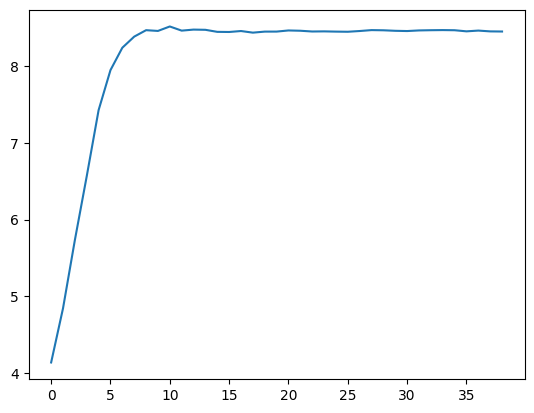

In [10]:
# should take ~8min on colab gpu. It will suboptimal due to the model size and default hyperparams!
config = TrainConfig(
    env_id="MiniGrid-EmptyGoalRandom-5x5",
    benchmark_id="trivial-1m",
    total_timesteps=500_000,
    num_envs=128,
    num_steps_per_env=100,
    num_steps_per_update=100,
    train_seed=1,
)
train_info = train(config)

In [11]:
total_rewards = {}
for x in range(1, 4):
    for y in range(1, 4):
        if x == 1 and y == 1:
            continue
        total_reward = evaluate(train_info, (x, y), "MiniGrid-EmptyGoalRandom-5x5")
        print(f"Goal position: {x}, {y}")
        print(f"Total reward: {total_reward}")
        total_rewards[(x, y)] = round(total_reward, 2)

/usr/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


Goal position: 1, 2
Total reward: 8.884000182151794
Goal position: 1, 3
Total reward: 9.172000050544739
Goal position: 2, 1
Total reward: 9.891999959945679
Goal position: 2, 2
Total reward: 0.9729999899864197
Goal position: 2, 3
Total reward: 9.217000007629395
Goal position: 3, 1
Total reward: 9.792999923229218
Goal position: 3, 2
Total reward: 9.432999968528748
Goal position: 3, 3
Total reward: 9.351999878883362


In [23]:
from IPython.display import HTML, Video, display

# assume total_rewards is your dict mapping (x,y) → reward
# and fns is the list of filenames in the same order

# 1) List your filenames
fns = []
for x in range(1, 4):
    for y in range(1, 4):
        if x == 1 and y == 1:
            continue
        fns.append(f"eval_rollout_MiniGrid-EmptyGoalRandom-5x5_({x}, {y}).mp4")

blocks = []
for (x, y), fn in zip(total_rewards.keys(), fns):
    # 1) get the reward
    rew = total_rewards[(x, y)]
    # 2) grab the embedded HTML for the video
    vid_html = Video(fn, embed=True)._repr_html_()
    # 3) build a little column: video on top, caption below
    block = f"""
    <div style="display:flex; flex-direction:column; align-items:center; margin:5px;">
      {vid_html}
      <div style="margin-top:4px; font-size:0.9em; color:red;">
        Goal ({x},{y}) - Reward: {rew}
      </div>
    </div>
    """
    blocks.append(block)

# 4) stitch them into one flex row
html = f"""
<div style="display:flex; gap:10px; flex-wrap:wrap;">
  {''.join(blocks)}
</div>
"""
html_output = HTML(html)
display(html_output)

In [24]:
save_html(html_output, "MiniGrid-EmptyGoalRandom-5x5_results")

Optionally, we can see the proportion of each goal_position that was used during training.


In [22]:
goal_positions = train_info["goal_positions"].reshape(-1, 2).tolist()
counts = {}
for i in range(len(goal_positions)):
    key = tuple(goal_positions[i])
    counts[key] = counts.get(key, 0) + 1
print(counts)

{(2, 1): 621, (3, 1): 653, (3, 2): 667, (1, 3): 611, (2, 3): 626, (1, 2): 559, (3, 3): 639, (2, 2): 616}


### On Grid Size 6x6


Num devices: 1, Num meta updates: 203
Compiling...
Done in 24.55s.
Training...
Done in 1.82min
Final return:  9.530200958251953


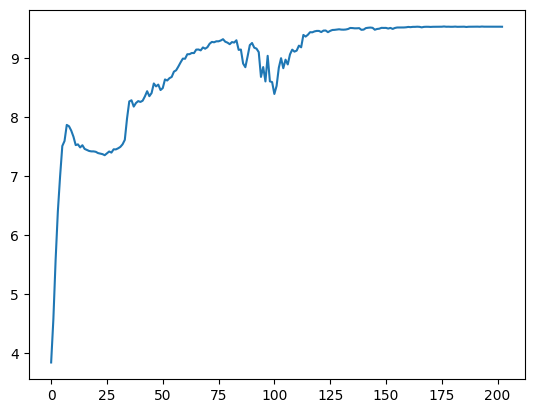

In [25]:
# should take ~8min on colab gpu. It will suboptimal due to the model size and default hyperparams!
config = TrainConfig(
    env_id="MiniGrid-EmptyGoalRandom-6x6",
    benchmark_id="trivial-1m",
    total_timesteps=5_000_000,
    num_envs=128,
    num_steps_per_env=192,
    num_steps_per_update=192,
    train_seed=1,
)
train_info = train(config)

In [26]:
total_rewards = {}
for x in range(1, 5):
    for y in range(1, 5):
        if x == 1 and y == 1:
            continue
        total_reward = evaluate(train_info, (x, y), "MiniGrid-EmptyGoalRandom-6x6")
        print(f"Goal position: {x}, {y}")
        print(f"Total reward: {total_reward}")
        print("--------")
        total_rewards[(x, y)] = round(total_reward, 2)

/usr/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


Goal position: 1, 2
Total reward: 9.04375022649765
--------
Goal position: 1, 3
Total reward: 9.099999904632568
--------
Goal position: 1, 4
Total reward: 9.231249809265137
--------
Goal position: 2, 1
Total reward: 9.937499761581421
--------
Goal position: 2, 2
Total reward: 9.712499976158142
--------
Goal position: 2, 3
Total reward: 9.693750202655792
--------
Goal position: 2, 4
Total reward: 9.368749976158142
--------
Goal position: 3, 1
Total reward: 9.87500011920929
--------
Goal position: 3, 2
Total reward: 9.637500166893005
--------
Goal position: 3, 3
Total reward: 9.518750011920929
--------
Goal position: 3, 4
Total reward: 9.450000166893005
--------
Goal position: 4, 1
Total reward: 9.81249988079071
--------
Goal position: 4, 2
Total reward: 9.681249976158142
--------
Goal position: 4, 3
Total reward: 9.618749797344208
--------
Goal position: 4, 4
Total reward: 9.550000071525574
--------


In [30]:
fns = []
for x in range(1, 5):
    for y in range(1, 5):
        if x == 1 and y == 1:
            continue
        fns.append(f"eval_rollout_MiniGrid-EmptyGoalRandom-6x6_({x}, {y}).mp4")

blocks = []
for (x, y), fn in zip(total_rewards.keys(), fns):
    # 1) get the reward
    rew = total_rewards[(x, y)]
    # 2) grab the embedded HTML for the video
    vid_html = Video(fn, embed=True)._repr_html_()
    # 3) build a little column: video on top, caption below
    block = f"""
    <div style="display:flex; flex-direction:column; align-items:center; margin:5px;">
      {vid_html}
      <div style="margin-top:4px; font-size:0.9em; color:red;">
        Goal ({x},{y}) - Reward: {rew}
      </div>
    </div>
    """
    blocks.append(block)

# 4) stitch them into one flex row
html = f"""
<div style="display:flex; gap:10px; flex-wrap:wrap;">
  {''.join(blocks)}
</div>
"""

html_output = HTML(html)
display(html_output)

# Good demos:
# (2, 3)
# (3, 2)
# (3, 3)

In [31]:
save_html(html_output, "MiniGrid-EmptyGoalRandom-6x6_results")

### On Grid Size 8x8


Num devices: 1, Num meta updates: 1017
Compiling...
Done in 24.61s.
Training...
Done in 12.14min
Final return:  9.590869903564453


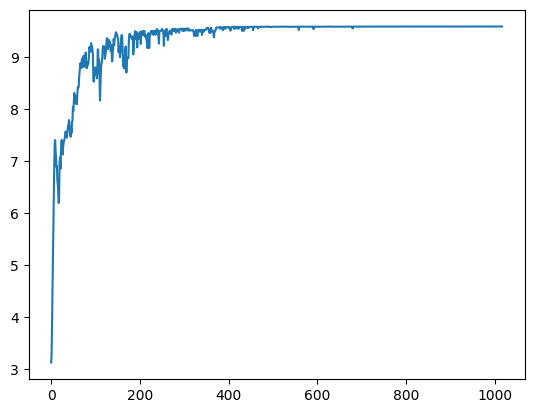

In [40]:
# should take ~8min on colab gpu. It will suboptimal due to the model size and default hyperparams!
config = TrainConfig(
    env_id="MiniGrid-EmptyGoalRandom-8x8",
    benchmark_id="trivial-1m",
    total_timesteps=50_000_000,
    num_envs=256,
    num_steps_per_env=192,
    num_steps_per_update=192,
    train_seed=1,
)
train_info = train(config)

Intuitively, I thought num_steps_per_env should be much higher than 6x6. However, after some experimentation using the same value of 192 (as in the 6x6 experiments) yielded better (?) results, although it might just be noise.


In [41]:
total_rewards = {}
for x in range(1, 7):
    for y in range(1, 7):
        if x == 1 and y == 1:
            continue
        total_reward = evaluate(train_info, (x, y), "MiniGrid-EmptyGoalRandom-8x8")
        print(f"Goal position: {x}, {y}")
        print(f"Total reward: {total_reward}")
        print("--------")
        total_rewards[(x, y)] = round(total_reward, 2)

Goal position: 1, 2
Total reward: 9.22656238079071
--------
Goal position: 1, 3
Total reward: 9.261718988418579
--------
Goal position: 1, 4
Total reward: 9.296875
--------
Goal position: 1, 5
Total reward: 9.332031011581421
--------
Goal position: 1, 6
Total reward: 9.40234363079071
--------
Goal position: 2, 1
Total reward: 9.964843988418579
--------
Goal position: 2, 2
Total reward: 9.433984339237213
--------
Goal position: 2, 3
Total reward: 9.381249785423279
--------
Goal position: 2, 4
Total reward: 9.416406333446503
--------
Goal position: 2, 5
Total reward: 9.486718952655792
--------
Goal position: 2, 6
Total reward: 9.437500238418579
--------
Goal position: 3, 1
Total reward: 9.92968738079071
--------
Goal position: 3, 2
Total reward: 9.785546660423279
--------
Goal position: 3, 3
Total reward: 9.697656273841858
--------
Goal position: 3, 4
Total reward: 9.69414085149765
--------
Goal position: 3, 5
Total reward: 9.521875023841858
--------
Goal position: 3, 6
Total reward: 9.4

In [43]:
fns = []
for x in range(1, 7):
    for y in range(1, 7):
        if x == 1 and y == 1:
            continue
        fns.append(f"eval_rollout_MiniGrid-EmptyGoalRandom-8x8_({x}, {y}).mp4")

blocks = []
for (x, y), fn in zip(total_rewards.keys(), fns):
    # 1) get the reward
    rew = total_rewards[(x, y)]
    # 2) grab the embedded HTML for the video
    vid_html = Video(fn, embed=True)._repr_html_()
    # 3) build a little column: video on top, caption below
    block = f"""
    <div style="display:flex; flex-direction:column; align-items:center; margin:5px;">
      {vid_html}
      <div style="margin-top:4px; font-size:0.9em; color:red;">
        Goal ({x},{y}) - Reward: {rew}
      </div>
    </div>
    """
    blocks.append(block)

# 4) stitch them into one flex row
html = f"""
<div style="display:flex; gap:10px; flex-wrap:wrap;">
  {''.join(blocks)}
</div>
"""

html_output = HTML(html)
display(html_output)

# Good demos:
# (3, 3)
# (4, 3)

In [44]:
save_html(html_output, "MiniGrid-EmptyGoalRandom-8x8_results")

The strategy learned is good, but it is not optimal. After finding the goal, the route taken by the agent to reach the goal on subsequent episodes is not the shortest path for many of the goal positions.

- Re-train, save all weights so we can always run the good-policy models.
- Try runnning seeded experiments for 8x8 with different num_steps_per_env to see if that really is the factor deciding performance.
